#Importing the Dataset

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Define the base path to your dataset


# Load the CSV files
train_data = pd.read_csv("/content/team7_hi_train.csv")
valid_data = pd.read_csv("/content/team7_hi_valid.csv")
test_data  = pd.read_csv("/content/team7_hi_test.csv")

# Display a few rows to inspect
print("Train Sample:")
print(train_data.head())

Train Sample:
                                              source  \
0  However, Paes, who was partnering Australia's ...   
1  Whosoever desires the reward of the world, wit...   
2  The value of insects in the biosphere is enorm...   
3  Mithali To Anchor Indian Team Against Australi...   
4  After the assent of the Honble President on 8t...   

                                              target  
0  आस्ट्रेलिया के पाल हेनली के साथ जोड़ी बनाने वाल...  
1  और जो शख्स (अपने आमाल का) बदला दुनिया ही में च...  
2  जैव-मंडल में कीड़ों का मूल्य बहुत है, क्योंकि ...  
3    आस्ट्रेलिया के खिलाफ वनडे टीम की कमान मिताली को  
4  8 सितम्‍बर, 2016 को माननीय राष्‍ट्रपति की स्‍व...  


# Tokenizing & Embedding English Words

In [3]:
def tokenize(text):
    return text.lower().split()

In [4]:
def build_vocab(texts, tokenizer):
    vocab = {}
    index = 1  # Start indexing from 1 (0 reserved for <pad>)

    for text in texts:
        tokens = tokenizer(text)
        for token in tokens:
            if token not in vocab:
                vocab[token] = index
                index += 1

    # Special tokens
    vocab['<pad>'] = 0
    vocab['<sos>'] = index
    index += 1
    vocab['<eos>'] = index
    index += 1
    vocab['<unk>'] = index

    return vocab


In [5]:
fraction = 1.0
subset_size = int(len(train_data) * fraction)

train_subset = train_data.iloc[:subset_size]
src_vocab = build_vocab(train_subset['source'],tokenizer = tokenize)
# tgt_vocab = build_vocab(train_subset['target'])

In [6]:
def load_glove_embeddings(path, vocab, embed_dim):
    embeddings = np.random.uniform(-0.1, 0.1, (len(vocab), embed_dim))
    word_to_idx = vocab
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word_to_idx:
                embeddings[word_to_idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

# Load GloVe (assuming 200d vectors, change to match your file)
glove_path = '/content/glove.6B.200d.txt'  # Path to your GloVe file
src_embedding_matrix = load_glove_embeddings(glove_path, src_vocab, embed_dim=200)

In [7]:
src_embedding_matrix.shape

torch.Size([92387, 200])

# Tokenizing & Embedding Gujarati Words

In [8]:
# !pip install transformers indic-nlp-library

from transformers import AutoTokenizer

tokenizer_indic = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
model_indic = AutoModel.from_pretrained("ai4bharat/indic-bert")
model_indic.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_indic.to(device)
def indic_tokenizer(text):
    return tokenizer_indic.tokenize(text)
tgt_vocab = build_vocab(train_subset['target'], tokenizer=indic_tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

In [9]:
def get_indicbert_embeddings(vocab, tokenizer, model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    emb_layer = model.get_input_embeddings()
    embed_dim = emb_layer.embedding_dim

    embeddings = torch.zeros(len(vocab), embed_dim)
    for token, idx in tqdm(vocab.items(), total=len(vocab)):
        if token in tokenizer.vocab:
            tid = tokenizer.convert_tokens_to_ids(token)
            embeddings[idx] = emb_layer.weight[tid].detach().cpu()
        else:
            embeddings[idx] = torch.zeros(embed_dim)
    return embeddings

tgt_embedding_matrix = get_indicbert_embeddings(tgt_vocab, tokenizer_indic, model_indic)


100%|██████████| 6870/6870 [14:13<00:00,  8.05it/s]


In [10]:
tgt_embedding_matrix.shape

torch.Size([6870, 128])

In [11]:
np.savetxt("tgt_embedding_matrix.txt", tgt_embedding_matrix.numpy())

In [12]:
class TranslationDataset(Dataset):
    def __init__(self, dataframe, src_vocab, tgt_vocab):
        self.source_texts = dataframe['source'].tolist()
        self.target_texts = dataframe['target'].tolist()
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        src = [self.src_vocab['<sos>']] + [self.src_vocab.get(word, self.src_vocab['<unk>']) for word in tokenize(self.source_texts[idx])] + [self.src_vocab['<eos>']]
        tgt = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(word, self.tgt_vocab['<unk>']) for word in indic_tokenizer(self.target_texts[idx])] + [self.tgt_vocab['<eos>']]
        return torch.tensor(src), torch.tensor(tgt)

In [13]:
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=src_vocab['<pad>'])
    tgt_batch = pad_sequence(tgt_batch, padding_value=tgt_vocab['<pad>'])
    return src_batch, tgt_batch

In [14]:
train_dataset = TranslationDataset(train_data, src_vocab, tgt_vocab)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

valid_dataset = TranslationDataset(valid_data, src_vocab, tgt_vocab)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [15]:
tgt_embedding_matrix = torch.tensor(np.loadtxt("tgt_embedding_matrix.txt"), dtype=torch.float)

In [16]:
def make_pad_mask(seq, pad_idx):
    """
    Create padding mask for a batch of sequences.
    seq: (batch_size, seq_len) of token indices
    Returns: (batch_size, seq_len) bool mask where True indicates pad.
    """
    return (seq == pad_idx)

def generate_square_subsequent_mask(sz):
    """
    Create a causal (subsequent) mask to prevent attending to future positions.
    Returns a (sz, sz) float tensor where positions (i,j) with j>i are -inf, else 0.
    """
    mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    return mask

In [17]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a matrix of shape (max_len, d_model) with positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))  # (d_model/2)

        # Apply sin to even indices in the array; cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices

        pe = pe.unsqueeze(1)  # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 src_vocab_size,
                 tgt_vocab_size,
                 src_embed_matrix,    # torch.Tensor (src_vocab, 200)
                 tgt_embed_matrix,    # torch.Tensor (tgt_vocab, 768)
                 src_pad_idx,
                 tgt_pad_idx,
                 d_model=256,         # common model dim
                 nhead=8,
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 dim_feedforward=512,
                 dropout=0.1):
        super().__init__()

        # 1) Embedding layers
        self.src_embedding = nn.Embedding.from_pretrained(src_embed_matrix, freeze=True)
        self.tgt_embedding = nn.Embedding.from_pretrained(tgt_embed_matrix, freeze=True)

        # 2) Project both to d_model
        self.src_proj = nn.Linear(self.src_embedding.embedding_dim, d_model)
        self.tgt_proj = nn.Linear(self.tgt_embedding.embedding_dim, d_model)

        # 3) Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # 4) Core Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False
        )

        # 5) Final projection to target vocab
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)

        # 6) Padding indices (for mask creation)
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx

    def forward(self,
                src,                    # (src_len, batch)
                tgt,                    # (tgt_len, batch)
                src_mask=None,          # optional, generally None
                tgt_mask=None,          # (tgt_len, tgt_len)
                src_key_padding_mask=None,   # (batch, src_len)
                tgt_key_padding_mask=None,   # (batch, tgt_len)
                memory_key_padding_mask=None # (batch, src_len)
                ):
        # 1) Embed + project + position
        src_emb = self.src_embedding(src)       # (src_len, batch, 200)
        src_emb = self.src_proj(src_emb)        # → (src_len, batch, d_model)
        src_emb = self.pos_encoder(src_emb)     # + positional

        tgt_emb = self.tgt_embedding(tgt)       # (tgt_len, batch, 768)
        tgt_emb = self.tgt_proj(tgt_emb)        # → (tgt_len, batch, d_model)
        tgt_emb = self.pos_encoder(tgt_emb)     # + positional

        # 2) Transformer
        output = self.transformer(
            src_emb, tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

        # 3) Project to vocab
        return self.output_layer(output)       # (tgt_len, batch, tgt_vocab_size)

# Training the Model

In [32]:
def make_pad_mask(seq, pad_idx):
    ## REMOVE TRANSPOSE WHILE TESTING
    return (seq == pad_idx).transpose(0, 1)  # (batch, seq_len)


In [19]:
def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


In [20]:
len(valid_loader)

1250

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/20:   0%|          | 0/4375 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Epoch 1/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.68it/s]


Epoch 1/20 — Training Loss: 4.9753 | Validation Loss: 4.5420


Epoch 2/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.69it/s]


Epoch 2/20 — Training Loss: 4.3568 | Validation Loss: 4.1940


Epoch 3/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.79it/s]


Epoch 3/20 — Training Loss: 4.0688 | Validation Loss: 3.9829


Epoch 4/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.61it/s]


Epoch 4/20 — Training Loss: 3.8752 | Validation Loss: 3.8349


Epoch 5/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.74it/s]


Epoch 5/20 — Training Loss: 3.7340 | Validation Loss: 3.7310


Epoch 6/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.69it/s]


Epoch 6/20 — Training Loss: 3.6210 | Validation Loss: 3.6383


Epoch 7/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.63it/s]


Epoch 7/20 — Training Loss: 3.5312 | Validation Loss: 3.5719


Epoch 8/20: 100%|██████████| 4375/4375 [02:23<00:00, 30.46it/s]


Epoch 8/20 — Training Loss: 3.4555 | Validation Loss: 3.5126


Epoch 9/20: 100%|██████████| 4375/4375 [02:23<00:00, 30.51it/s]


Epoch 9/20 — Training Loss: 3.3878 | Validation Loss: 3.4677


Epoch 10/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.75it/s]


Epoch 10/20 — Training Loss: 3.3303 | Validation Loss: 3.4282


Epoch 11/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.71it/s]


Epoch 11/20 — Training Loss: 3.2772 | Validation Loss: 3.3893


Epoch 12/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.77it/s]


Epoch 12/20 — Training Loss: 3.2288 | Validation Loss: 3.3586


Epoch 13/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.72it/s]


Epoch 13/20 — Training Loss: 3.1875 | Validation Loss: 3.3298


Epoch 14/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.62it/s]


Epoch 14/20 — Training Loss: 3.1481 | Validation Loss: 3.3058


Epoch 15/20: 100%|██████████| 4375/4375 [02:36<00:00, 27.92it/s]


Epoch 15/20 — Training Loss: 3.1106 | Validation Loss: 3.2795


Epoch 16/20: 100%|██████████| 4375/4375 [02:24<00:00, 30.32it/s]


Epoch 16/20 — Training Loss: 3.0773 | Validation Loss: 3.2633


Epoch 17/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.63it/s]


Epoch 17/20 — Training Loss: 3.0462 | Validation Loss: 3.2458


Epoch 18/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.63it/s]


Epoch 18/20 — Training Loss: 3.0158 | Validation Loss: 3.2294


Epoch 19/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.65it/s]


Epoch 19/20 — Training Loss: 2.9882 | Validation Loss: 3.2134


Epoch 20/20: 100%|██████████| 4375/4375 [02:22<00:00, 30.72it/s]


Epoch 20/20 — Training Loss: 2.9617 | Validation Loss: 3.1998


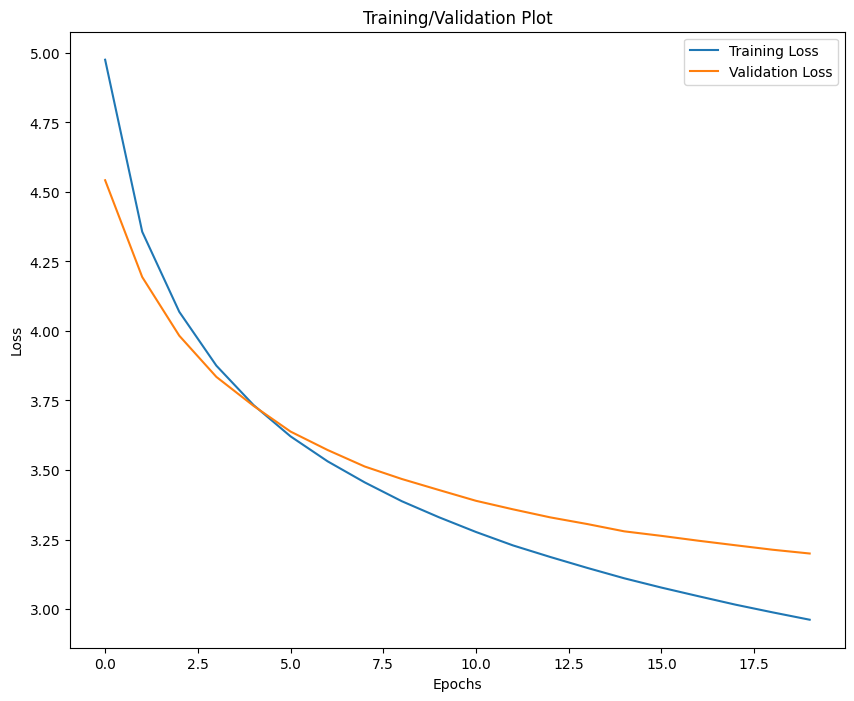

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# ── Assumes these are already defined/imported: ────────────────────────────────
# Seq2SeqTransformer, make_pad_mask, generate_square_subsequent_mask
# train_loader, src_vocab, tgt_vocab, src_embedding_matrix, tgt_embedding_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Instantiate the model
d_model = 256
model = Seq2SeqTransformer(
    src_vocab_size = len(src_vocab),
    tgt_vocab_size = len(tgt_vocab),
    src_embed_matrix = src_embedding_matrix.to(device),
    tgt_embed_matrix = tgt_embedding_matrix.to(device),
    src_pad_idx = src_vocab['<pad>'],
    tgt_pad_idx = tgt_vocab['<pad>'],
    d_model = d_model
).to(device)

# 2) Loss & Optimizer
criterion = nn.CrossEntropyLoss(ignore_index= tgt_vocab['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 3) Training Loop
EPOCHS, train_loss_list, val_loss_list, best_valid_loss = 20, [], [], float('inf')
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss, valid_loss = 0, 0

    for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        # src, tgt: (seq_len, batch_size)
        src, tgt = src.to(device), tgt.to(device)

        # 3.1) Prepare input & target
        tgt_input  = tgt[:-1, :]  # remove last token
        tgt_output = tgt[1:, :]   # remove first token

        # 3.2) Build masks
        # --- Padding masks: True for positions to mask
        # Pass the original (seq_len, batch_size) tensor to make_pad_mask
        # make_pad_mask will transpose it to (batch_size, seq_len)
        src_key_padding_mask = make_pad_mask(src, src_vocab['<pad>']).to(device)
        tgt_key_padding_mask = make_pad_mask(tgt_input, tgt_vocab['<pad>']).to(device)
        memory_key_padding_mask = src_key_padding_mask

        # --- Causal mask for decoder (prevent peeking ahead)
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(0)).to(device)

        # 3.3) Forward + Loss
        optimizer.zero_grad()
        logits = model(
            src,
            tgt_input,
            src_mask=None,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask, # (batch, src_len)
            tgt_key_padding_mask=tgt_key_padding_mask, # (batch, tgt_len)
            memory_key_padding_mask=memory_key_padding_mask # (batch, src_len)
        )
        # logits: (tgt_len, batch_size, tgt_vocab_size)

        # Flatten for loss: ignore pad index
        loss = criterion(
            logits.view(-1, logits.size(-1)),
            tgt_output.reshape(-1)
        )
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    for src, tgt in valid_loader:
        src, tgt = src.to(device), tgt.to(device)

        # 3.1) Prepare input & target
        tgt_input  = tgt[:-1, :]  # remove last token
        tgt_output = tgt[1:, :]   # remove first token

        # 3.2) Build masks
        # --- Padding masks: True for positions to mask
        # Pass the original (seq_len, batch_size) tensor to make_pad_mask
        # make_pad_mask will transpose it to (batch_size, seq_len)
        src_key_padding_mask = make_pad_mask(src, src_vocab['<pad>']).to(device)
        tgt_key_padding_mask = make_pad_mask(tgt_input, tgt_vocab['<pad>']).to(device)
        memory_key_padding_mask = src_key_padding_mask

        # --- Causal mask for decoder (prevent peeking ahead)
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(0)).to(device)
        val_logits = model(
            src,
            tgt_input,
            src_mask=None,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask, # (batch, src_len)
            tgt_key_padding_mask=tgt_key_padding_mask, # (batch, tgt_len)
            memory_key_padding_mask=memory_key_padding_mask # (batch, src_len)
        )
        val_loss = criterion(
            val_logits.view(-1, logits.size(-1)),
            tgt_output.reshape(-1)
        )
        valid_loss += val_loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = valid_loss / len(valid_loader)

    if best_valid_loss > avg_val_loss:
        torch.save(model.state_dict(), 'transformer_weights_best.pth')
        best_valid_loss = avg_val_loss

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    print(f"Epoch {epoch}/{EPOCHS} — Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Validation Plot")
plt.legend()
plt.show()

## Inference

In [24]:
checkpoints = "/content/transformer_weights_best.pth"
model.load_state_dict(torch.load(checkpoints))

<All keys matched successfully>

In [25]:
import torch
from torch.utils.data import DataLoader
import pandas as pd

# 1) Create test Dataset & DataLoader
test_dataset = TranslationDataset(test_data, src_vocab, tgt_vocab)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# 2) Greedy decoding function
def greedy_decode(model, src, src_pad_idx, max_len, start_symbol):
    model.eval()
    device = next(model.parameters()).device

    src = src.to(device)
    src_key_padding_mask = make_pad_mask(src.transpose(0, 1), src_pad_idx).to(device)
    # src = src.transpose(0, 1)

    with torch.no_grad():
        emb = model.src_embedding(src)                    # [S, B, D]
        proj = model.src_proj(emb)                        # [S, B, D]
        pos = model.pos_encoder(proj)                     # [S, B, D]
        memory = model.transformer.encoder(
            pos,
            src_key_padding_mask=src_key_padding_mask      # [B, S]
        )

    ys = torch.full(
        (1, src.size(1)), start_symbol, dtype=torch.long, device=device
    )

    for i in range(max_len-1):
        tgt_key_padding_mask = make_pad_mask(ys.transpose(0, 1), tgt_vocab['<pad>']).to(device)
        tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device)

        with torch.no_grad():
            dec_emb  = model.tgt_embedding(ys)                  # [t, B, D]
            dec_proj = model.tgt_proj(dec_emb)                  # [t, B, D]
            dec_pos  = model.pos_encoder(dec_proj)
            # print(model.pos_encoder(model.tgt_proj(model.tgt_embedding(ys))).shape)
            # print(memory.shape)
            out = model.transformer.decoder(
                dec_pos,
                memory,
                tgt_mask=tgt_mask,
                memory_key_padding_mask=src_key_padding_mask,   # [B, S]
                tgt_key_padding_mask=tgt_key_padding_mask      # [B, t]
            )
            out = model.output_layer(out)

        prob = out[-1].softmax(dim=-1)
        next_word = torch.argmax(prob, dim=-1)

        ys = torch.cat([ys, next_word.unsqueeze(0)], dim=0)

        if next_word.item() == tgt_vocab['<eos>']:
            break

    return ys.squeeze(1).cpu().tolist()
# 3) Run evaluation


In [ ]:
results = []
token_ids_list = []

i=0
for src, tgt in test_loader:
    if i >=5:
        break
    i+=1
    pred_ids = greedy_decode(
        model=model,
        src=src,
        src_pad_idx=src_vocab['<pad>'],
        max_len=100,
        start_symbol=tgt_vocab['<sos>']
    )
    token_ids_list.append((src, tgt, pred_ids))

# 4) Convert token IDs to strings and store all info
eval_data = []

for src_tensor, tgt_tensor, pred_ids in token_ids_list:
    # Convert source
    src_tokens = [ list(src_vocab.keys())[list(src_vocab.values()).index(t.item())]
                   if t.item() in src_vocab.values() else '<unk>'
                   for t in src_tensor.squeeze(1) ]
    src_sentence = ' '.join(src_tokens)

    # Convert target ground truth
    tgt_tokens = [ list(tgt_vocab.keys())[list(tgt_vocab.values()).index(t.item())]
                   if t.item() in tgt_vocab.values() else '<unk>'
                   for t in tgt_tensor.squeeze(1) ]
    tgt_sentence = tokenizer_indic.convert_tokens_to_string(tgt_tokens)

    # Convert prediction
    pred_tokens = [ list(tgt_vocab.keys())[list(tgt_vocab.values()).index(t)]
                    if t in tgt_vocab.values() else '<unk>'
                    for t in pred_ids ]
    pred_sentence = tokenizer_indic.convert_tokens_to_string(pred_tokens)

    eval_data.append({
        'English': src_sentence,
        'Ground Truth': tgt_sentence,
        'Prediction': pred_sentence
    })

# 5) Save to CSV
df = pd.DataFrame(eval_data)
df.to_csv('translation_results.csv', index=False)
print("Saved predictions to translation_results.csv")


In [26]:
# Print just 4 examples with English, Ground Truth, and Prediction

for i, (src, tgt) in enumerate(test_loader):
    if i >= 4:
        break

    # Decode prediction
    pred_ids = greedy_decode(
        model=model,
        src=src,
        src_pad_idx=src_vocab['<pad>'],
        max_len=100,
        start_symbol=tgt_vocab['<sos>']
    )

    # Convert English source
    src_tokens = [ list(src_vocab.keys())[list(src_vocab.values()).index(t.item())]
                   if t.item() in src_vocab.values() else '<unk>'
                   for t in src.squeeze(1) ]
    src_sentence = ' '.join(src_tokens)

    # Convert ground truth target
    tgt_tokens = [ list(tgt_vocab.keys())[list(tgt_vocab.values()).index(t.item())]
                   if t.item() in tgt_vocab.values() else '<unk>'
                   for t in tgt.squeeze(1) ]
    tgt_sentence = tokenizer_indic.convert_tokens_to_string(tgt_tokens)

    # Convert prediction
    pred_tokens = [ list(tgt_vocab.keys())[list(tgt_vocab.values()).index(t)]
                    if t in tgt_vocab.values() else '<unk>'
                    for t in pred_ids ]
    pred_sentence = tokenizer_indic.convert_tokens_to_string(pred_tokens)

    # Print output
    print(f"Example {i+1}")
    print("English      :", src_sentence)
    print("Ground Truth :", tgt_sentence)
    print("Prediction   :", pred_sentence)
    print("-" * 60)


Example 1
English      : <sos> the university grants commission has agreed to provide 2 credit points as an elective under the choice based credit system <unk> to students in higher educational institutions who would be undertaking and completing the <unk> <eos>
Ground Truth : <sos> यनवरसट अनदन आयग (ugc) उचच शकष ससथन क छतर क चइस बसड करडट ससटम (cbcs) क तहत वकलपक रप म 2 करडट अक दन पर सहमत ह गय ह.<eos>
Prediction   : <sos> वशववदयलय आयग न एक सथपत कय ह, जसम वदयरथय क तहत करडट क तहत एक ससथन क तहत करडट रप स वदयरथय क तहत करडट क तहत करडट क तहत करडट रप स परदन कय जएग।<eos>
------------------------------------------------------------
Example 2
English      : <sos> power of the mind <eos>
Ground Truth : <sos> मन क शकत<eos>
Prediction   : <sos> कय ह क शकत क शकत<eos>
------------------------------------------------------------
Example 3
English      : <sos> as weve made clear, the negotiations over the settlement of an outstanding claim were completely separate from the discussions about returning our

# Calculating BLEU Scores

In [27]:
!pip install nltk

In [30]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
nltk.download('punkt')
nltk.download('punkt_tab')

def compute_bleu_scores_k(model, test_data, src_vocab, tgt_vocab, tokenizer_indic, max_len=50):
    references = []
    hypotheses = []

    model.eval()
    device = next(model.parameters()).device
    i=0

    for idx, row in test_data.iterrows():
        if i>=1000:
            break
        i+=1
        # Tokenize and index source sentence
        src_tokens = row['source'].split()  # or use your tokenize() function
        src_indices = [src_vocab['<sos>']] + [src_vocab.get(w, src_vocab['<unk>']) for w in src_tokens] + [src_vocab['<eos>']]
        src_tensor = torch.tensor(src_indices).unsqueeze(1).to(device)  # (seq_len, 1)

        # Get prediction
        pred_ids = greedy_decode(
            model=model,
            src=src_tensor,
            src_pad_idx=src_vocab['<pad>'],
            max_len=max_len,
            start_symbol=tgt_vocab['<sos>']
        )

        # Convert prediction to tokens
        pred_tokens = [list(tgt_vocab.keys())[list(tgt_vocab.values()).index(t)]
                       if t in tgt_vocab.values() else '<unk>'
                       for t in pred_ids]

        # Remove special tokens
        pred_tokens = [tok for tok in pred_tokens if tok not in ['<sos>', '<eos>', '<pad>']]

        # Ground truth target
        tgt_tokens = tokenizer_indic.tokenize(row['target'])
        tgt_tokens = [tok for tok in tgt_tokens if tok not in ['<sos>', '<eos>', '<pad>']]

        # Tokenize for BLEU
        references.append([nltk.word_tokenize(tokenizer_indic.convert_tokens_to_string(tgt_tokens))])
        hypotheses.append(nltk.word_tokenize(tokenizer_indic.convert_tokens_to_string(pred_tokens)))

    # BLEU with smoothing
    smoothie = SmoothingFunction().method4

    print("\n🔍 BLEU Scores on Test Set:")
    print(f"BLEU-1 (Unigram):   {corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie):.4f}")
    print(f"BLEU-2 (Bigram):    {corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie):.4f}")
    print(f"BLEU-3 (Trigram):   {corpus_bleu(references, hypotheses, weights=(1/3, 1/3, 1/3, 0), smoothing_function=smoothie):.4f}")
    print(f"BLEU-4 (4-gram):    {corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie):.4f}")

# Example usage:
compute_bleu_scores_k(model, test_data, src_vocab, tgt_vocab, tokenizer_indic)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



🔍 BLEU Scores on Test Set:
BLEU-1 (Unigram):   0.1330
BLEU-2 (Bigram):    0.0696
BLEU-3 (Trigram):   0.0386
BLEU-4 (4-gram):    0.0223


In [38]:
model.transformer.encoder

TransformerEncoder(
  (layers): ModuleList(
    (0-2): 3 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [39]:
model.transformer.decoder

TransformerDecoder(
  (layers): ModuleList(
    (0-2): 3 x TransformerDecoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (dropout3): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)